In [34]:
# Importing basic libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from facenet_pytorch import MTCNN, InceptionResnetV1
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image
import torch

In [36]:
# Loading models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=0, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
resnet = ResNet50(weights='imagenet')

Processing image: ishaan.jpg 


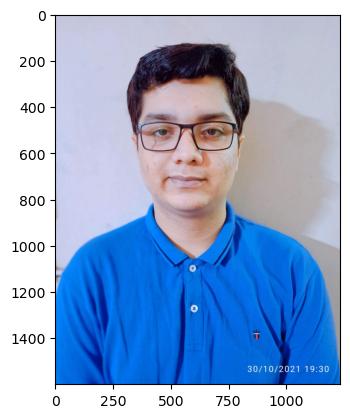

Processing image: raj.jpg 


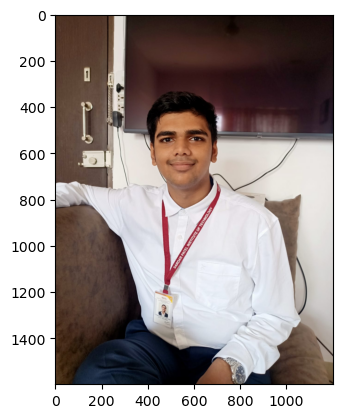

In [38]:
# Defining Known faces & embedding
known_faces = {
    "Ishaan": "ishaan.jpg",
    "Rajyavardhan": "raj.jpg"
}
known_embeddings = {}
for name, path in known_faces.items():
    img = cv2.imread(path)
    new_img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    print(f"Processing image: {path} ")
    plt.imshow(new_img)
    plt.show()
    face = mtcnn(img)
    if face is not None:
        face = face.unsqueeze(0).to(device)
        emb = facenet(face).detach().cpu().numpy()[0]
        emb = emb / np.linalg.norm(emb)
        known_embeddings[name] = emb
    else:
        print(f"{face} not detected")
np.save("known_embeddings.npy", known_embeddings)

Processing image: 


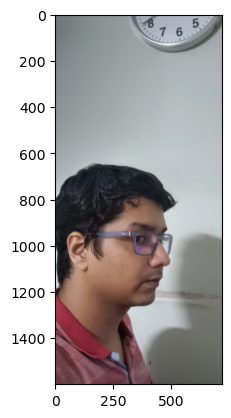

Face recognized as Ishaan (Similarity: 0.84)
Processing image: 


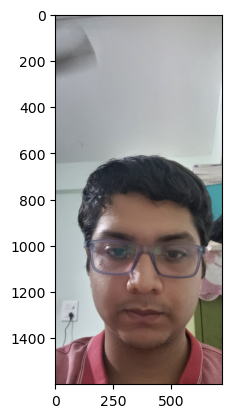

Face recognized as Ishaan (Similarity: 0.80)
Processing image: 


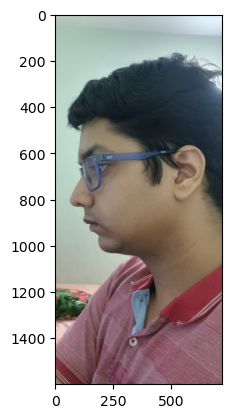

Face recognized as Ishaan (Similarity: 0.79)
Processing image: 


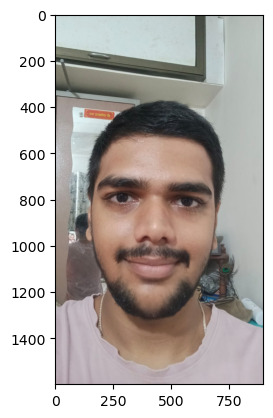

Face recognized as Rajyavardhan (Similarity: 0.87)
Processing image: 


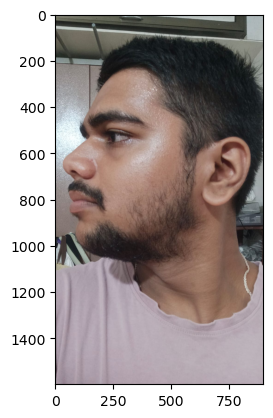

Face recognized as Rajyavardhan (Similarity: 0.75)
Processing image: 


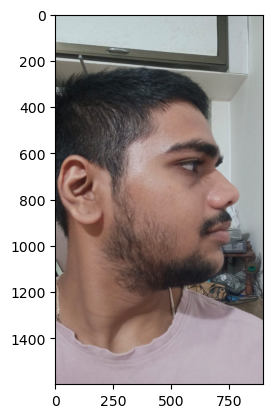

Face recognized as Rajyavardhan (Similarity: 0.68)


In [40]:
# Input images to process
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg","image4.jpg", "image5.jpg", "image6.jpg" ]
recognized_faces = []
fused_stack = []
for path in image_paths:
    img = Image.open(path).convert("RGB")
    fused_stack.append(np.array(img.resize((224, 224))))  
    print("Processing image: ")
    plt.imshow(img)
    plt.show()
    face = mtcnn(img)
    if face is not None:
        face = face.unsqueeze(0).to(device)
        emb = facenet(face).detach().cpu().numpy()[0]
        emb = emb / np.linalg.norm(emb)
        # Comparing it with the known embeddings
        best_match = "Unknown"
        best_score = -1
        for name, known_emb in known_embeddings.items():
            score = cosine_similarity([emb], [known_emb])[0][0]
            if score > best_score:
                best_match = name
                best_score = score
        label = best_match if best_score > 0.5 else "Unknown"
        recognized_faces.append((os.path.basename(path), label, best_score))
        print(f"Face recognized as {label} (Similarity: {best_score:.2f})")
    else:
        recognized_faces.append((os.path.basename(path), "No face detected", 0))
        print("No face detected in image.")

In [42]:
# Fusion and object detection
fused_image = np.mean(fused_stack, axis=0).astype(np.uint8)
resnet_input = cv2.resize(fused_image, (224, 224))
resnet_input = keras_image.img_to_array(resnet_input)
resnet_input = np.expand_dims(resnet_input, axis=0)
resnet_input = preprocess_input(resnet_input)
preds = resnet.predict(resnet_input)
decoded = decode_predictions(preds, top=3)[0]
print("\nTop 3 Objects Detected in Fused Image:")
for i, obj in enumerate(decoded):
    print(f"{i+1}. {obj[1]} ({obj[2]*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Top 3 Objects Detected in Fused Image:
1. mosquito_net (90.88%)
2. jellyfish (7.16%)
3. plastic_bag (0.27%)


In [44]:
# Printing the summary of face recognition results
print("\nSummary of Face Recognition:")
for filename, label, score in recognized_faces:
    print(f"{filename}: {label} (Score: {score:.2f})")


Summary of Face Recognition:
image1.jpg: Ishaan (Score: 0.84)
image2.jpg: Ishaan (Score: 0.80)
image3.jpg: Ishaan (Score: 0.79)
image4.jpg: Rajyavardhan (Score: 0.87)
image5.jpg: Rajyavardhan (Score: 0.75)
image6.jpg: Rajyavardhan (Score: 0.68)
